In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
import numpy as np
import scipy.stats as ss
import random
import os
import pandas as pd
from iotools.readRPKM import ReadRPKM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import linear_model

def knn_correction(expr, K):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn, neighbour_comp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import operator
import json
from utils import utils
json_file = "../gtex_v8_metadata.json"
tissue_file = "../plots/tissues.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]
select_tissues = ['ms', 'wb', 'sse', 'as', 'hlv', 'colt', 'bco', 'aa', 'ag' , 'ac', 'bca', 'ac', 'fib', 'bceh', 'bhi', 'tes', 'nt', 'thy']


In [6]:
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

def scale_covariates(df_cov):
    # scale covariates
    NAmask = pd.isna(df_cov)
    means = np.mean(df_cov.T)
    stds = np.std(df_cov.T)
    diff = (df_cov.T[~NAmask.T] - means) / stds
    return diff.T

def scale_covariates_nan(df_cov):
    new_df = pd.DataFrame([])
    for r in df_cov.index:
        NAmask = pd.isna(df_cov.loc[r])
        means = np.mean(df_cov.loc[r].T)
        stds = np.std(df_cov.loc[r].T)
        diff = pd.DataFrame((df_cov.loc[r][~NAmask] - means) / stds )
        new_df = pd.concat([new_df, diff.T],sort=False)
        # Nan values will be added as other sample names are introduced and gaps will be filled with Nans
    return new_df

In [7]:
## Subject Covariates from GTEx_v8 as in "The impact of rare variation on gene expression across tissues"
subj_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002742.v8.p2.c1.GTEx_Subject_Phenotypes.GRU.txt"
subj_df = pd.read_csv(subj_file, comment="#", sep="\t", header=0)

cov_dict = dict()
# cov_dict['DTHTYP']    = "Specific cause of death based on ICD-10 coding"
# cov_dict['DTHICD10']  = "ICD-10 Code for cause of death"
# cov_dict['DTHCLS']    = "Classification of death based on ICD-10 coding"
# cov_dict['DTHCAT']    = "Category of death based on ICD-10 coding"
# cov_dict['DTHCOD']    = "Immediate Cause Of Death"
# cov_dict['DTHFUCOD']  = "First Underlying Cause Of Death"
# cov_dict['DTHCERT']   = "Death Certificate Available"
# cov_dict['MHASCITES'] = "Ascites"
# cov_dict['DTHLUCOD']  = "Last Underlying Cause Of Death"

# cov_dict['TRISCH']    = "Ischemic Time"
cov_dict["TRDNISCH"]  = "Total Ischemic time for a donor"
cov_dict["TRISCHD"]   = "Ischemic Time (Minutes)"
cov_dict['DTHRFG']    = "Body Refrigerated"

cov_dict['MHSRC']     = 'Primaty History Source'
cov_dict["LBPRRVDRL"] = "PRR VDRL Serology"
cov_dict["LBHBCABM"]  = "HBcAb IgM Serology"
cov_dict["DTHATPSY"]  = "Autopsy performed By Coroner or ME"
cov_dict['AGE']       = "Age"
cov_dict['RACE']      = "Race"
#cov_dict["ETHNCTY"]   = "Ethnicity"
cov_dict['MHABNWBC']  = "Abnormal WBC"
#cov_dict['TRCRTMPL']  = "Core Body Temperature - Location of measurment"
cov_dict["TRCRTMP"]   = "Core Body Temperature"
cov_dict["SEX"]       = "Sex"
cov_dict['DTHVNT']    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["DTHVNTD"]   = "Time Interval On Ventilator"
# cov_dict["DTHVNTDU"]  = "Time Interval On Ventilator Unit"
cov_dict["TRVNTSR"]   = "On ventilator less than 24 hours"
cov_dict["DTHVNT"]    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["LBEBVGAB"]  = "EBV IgG Ab"
cov_dict["LBEBVMAB"]  = "EBV IgM Ab"
cov_dict["LBCMVTAB"]  = "CMV Total Ab"
cov_dict['COHORT']    = "Cohort"
# cov_dict["TRCHSTIN"]  = "Time of Chest Incision"
cov_dict["TRCHSTIND"] = "Time of Chest Incision (Minutes)"
cov_dict['DTHPLCE']   = "Place of Death"
cov_dict['DTHHRDY']   = "Hardy Scale"

subj_covariates= list(cov_dict.keys()) 
select_columns = ["SUBJID"] + subj_covariates
SUBJ_DF = subj_df[select_columns]

In [8]:
## Sample Covariates 
sample_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002743.v8.p2.c1.GTEx_Sample_Attributes.GRU.txt"
sample_df = pd.read_csv(sample_file, comment="#", sep="\t", header=0)

sample_cov_dict = dict()
sample_cov_dict["SMTRSCPT"] = "Transcripts Detected" #: Total number of transcripts with at least 5 exon mapping reads"
sample_cov_dict["SMGNSDTC"] = "Genes detected"
sample_cov_dict["SMSPLTRD"] = "Split Reads"
sample_cov_dict["SMCENTER"] = "Code for BSS collection site"
sample_cov_dict["SMATSSCR"] = "Autolysis Score"
sample_cov_dict["SME2PCTS"] = "End 2 % Sense" # : Percentage of intragenic End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME1SNSE"] = "End 1 Sense" # : Number of End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SME2SNSE"] = "End 2 Sense" # : Number of End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME2ANTI"] = "End 2 Antisense" # : Number of reads that were sequenced in the antisense direction"
sample_cov_dict["SME1ANTI"] = "End 1 Antisense" # : Number of End 1 reads that were sequenced in the antisense direction"
sample_cov_dict["SME1MPRT"]  = "End 1 Mapping Rate" # : the number of End 1 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME2MPRT"]  = "End 2 Mapping Rate" # : the number of End 2 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME1MMRT"]  = "End 1 Mismatch Rate" # : The number of End 1 bases not matching the reference divided by the total number of End 1 bases."
sample_cov_dict["SME2MMRT"]  = "End 2 Mismatch Rate" #  The number of End 2 bases not matching the reference divided by the total number of End 2 bases."
sample_cov_dict["SMMPPDUN"]  = "Mapped Unique" # : Number of reads that were aligned and did not have duplicate flags"
sample_cov_dict["SMMPPD"]    = "Mapped" # : Total number of reads aligned/mapped"
sample_cov_dict["SMMPPDPR"]  = "Mapped Pairs" # :Total number of pairs for which both ends map"
sample_cov_dict["SMRDTTL"]   = "Total reads" #  (filtered to exclude reads with vendor fail or alternative alignment flags)"
sample_cov_dict["SMMFLGTH"]  = "Fragment Length Mean"
sample_cov_dict["SMSFLGTH"]  = "Fragment Length StdDev" # : The fragment length is the distance between the start of an upstream read and the end of the downstream pair mate"
sample_cov_dict["SMALTALG"]  = "Alternative Aligments" # : duplicate read entries providing alternative coordinates"
sample_cov_dict["SMNTERRT"]  = "Intergenic Rate" # : The fraction of reads that map to the genomic space between genes"
sample_cov_dict["SMNTRART"]  = "Intragenic Rate" # : The fraction of reads that map within genes (within introns or exons)"
sample_cov_dict["SMRRNART"]  = "RRNA Rate" # : Ratio of all reads aligned to rRNA regions to total reads"
sample_cov_dict["SMRRNANM"]  = "RRNA: Number of all reads" #  (duplicate and non-duplicate) aligning to ribosomal RNA regions"
sample_cov_dict["SMTSISCH"]  = "Total Ischemic time for a sample"
sample_cov_dict["SMRIN"]     = "RIN Number"
sample_cov_dict["SMNTRNRT"]  = "Intronic Rate" # : The fraction of reads that map within introns"
sample_cov_dict["SMEXNCRT"]  = "Exonic Rate" # : The fraction of reads that map within exons"
sample_cov_dict["SMEXPEFF"]  = "Expression Profiling Efficiency" # : Ratio of exon reads to total reads"
sample_cov_dict["SMGEBTCHD"] = "Date of genotype or expression batch"
sample_cov_dict["SMNABTCHT"] = "Type of nucleic acid isolation batch"
sample_cov_dict["SMGEBTCH"]  = "Genotype or Expression Batch ID"
sample_cov_dict["SMNABTCHD"] = "Date of nucleic acid isolation batch"
sample_cov_dict["SMNABTCH"]  = "Nucleic Acid Isolation Batch ID"

sample_cov_dict["SME1PCTS"] = "End 1 % Sense" # : Percentage of intragenic End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SMMAPRT"]  = "Mapping Rate" # : Ratio of total mapped reads to total reads"
sample_cov_dict["SMUNMPRT"] = "Unique Rate of Mapped" # : Unique reads divided by all mapped reads."
sample_cov_dict["SMMPUNRT"] = "Mapped Unique Rate of Total" # : Ratio of mapping of reads that were aligned and were not duplicates to total reads"
sample_cov_dict["SMESTLBS"] = "Estimated library size" # : Number of expected fragments based on the total reads and duplication rate assuming a Poisson distribution."

sample_cov_dict["SMTSD"]    = "Tissue Type"

sample_covariates= list(sample_cov_dict.keys()) 
select_columns = ["SAMPID"] + sample_covariates
# Make sure to select TruSeq RNA-seq experiments!! in SMGEBTCHT
# Remove FLAGGED samples! duh!
SAMPLE_DF = sample_df[sample_df["SMGEBTCHT"].str.match("TruSeq") & ~sample_df["SMTORMVE"].str.match("FLAGGED").fillna(False) ][select_columns]

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Factorize categories in both covariate sets
## Dates are just converted to consecutive number (but without any date ordering)

In [9]:
for c,t in zip(subj_covariates, SUBJ_DF[subj_covariates].dtypes):
    if t == "object":
        print(c, set(SUBJ_DF[c]),t)
        values, categories = SUBJ_DF[c].factorize()
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                cov_dict[new_cat_name] = f"{cov_dict[c]} - {categories[x]}"
                print(new_cat_name, categories[x])
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SUBJ_DF[new_cat_name] = new_values    
            SUBJ_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SUBJ_DF.loc[:,c] = values
            SUBJ_DF[c].replace({-1:np.nan}, inplace=True)

MHSRC {nan, 'Family Report', 'Medical Record'} object
MHSRC_0 Family Report
MHSRC_1 Medical Record
TRVNTSR {nan, 'On ventilator < 24 hours'} object


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

COHORT {'Organ Donor (OPO)', nan, 'Surgical', 'Postmortem'} object
COHORT_0 Postmortem
COHORT_1 Organ Donor (OPO)
COHORT_2 Surgical
DTHPLCE {nan, 'Hospice', 'At MVA scene', 'at scene of accident', 'Ambulance', 'Outpatient', 'police department', 'motor vehicle accident scene', "Decedent's home", 'Dead on arrival at hospital', 'Unknown', 'Nursing home/Long-term care facility', 'state park', 'Hospital inpatient', 'scene of accident', 'Emergency room'} object


In [10]:
for c,t in zip(sample_covariates, SAMPLE_DF[sample_covariates].dtypes):
    if t == "object":
        print(c, set(SAMPLE_DF[c]),t)
        if c == "SMTSD": # Don't do for tissue type
            continue
        values, categories = SAMPLE_DF[c].factorize()
        # if it has more than 4 categories, just leave it as is and assign numbers
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                sample_cov_dict[new_cat_name] = f"{sample_cov_dict[c]} - {categories[x]}"
                print(new_cat_name, categories[x])
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SAMPLE_DF[new_cat_name] = new_values
            SAMPLE_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SAMPLE_DF.loc[:,c] = values
            SAMPLE_DF[c].replace({-1:np.nan}, inplace=True)

SMCENTER {'C1, B1, A1', 'B1, A1', nan, 'C1, A1', 'D1, A1', 'B1', 'D1', 'C1'} object
SMGEBTCHD {nan, '04/10/2014', '02/19/2015', '11/06/2014', '04/02/2016', '01/27/2017', '02/22/2017', '05/07/2017', '08/22/2015', '03/31/2014', '07/31/2016', '07/18/2013', '04/23/2015', '02/12/2017', '01/18/2014', '04/11/2014', '12/20/2014', '05/12/2015', '05/03/2017', '03/04/2015', '05/12/2017', '03/27/2015', '05/16/2016', '05/11/2013', '03/22/2016', '08/31/2012', '08/01/2013', '11/21/2013', '03/20/2014', '12/19/2014', '06/06/2015', '01/23/2016', '06/16/2016', '04/16/2013', '10/20/2013', '01/18/2015', '06/08/2012', '04/01/2014', '03/23/2015', '09/11/2012', '03/27/2014', '05/19/2015', '09/14/2016', '03/07/2015', '07/20/2015', '11/01/2016', '05/31/2017', '01/27/2013', '09/19/2013', '06/05/2017', '04/06/2015', '03/05/2014', '02/19/2014', '03/31/2017', '08/09/2014', '07/26/2016', '11/30/2016', '03/14/2015', '08/02/2014', '01/24/2017', '04/18/2013', '04/03/2014', '03/02/2014', '06/04/2013', '03/25/2017', '01/

In [11]:
# # Check for scaling covariates
# new_df = pd.DataFrame([])
# df_cov = TISSUE_COVS[nb_df.columns].copy(deep=True)
# for r in df_cov.index:
#     print(r)
#     NAmask = pd.isna(df_cov.loc[r])
#     means = np.mean(df_cov.loc[r].T)
#     stds = np.std(df_cov.loc[r].T)
#     diff = pd.DataFrame((df_cov.loc[r][~NAmask] - means) / stds )
#     print(new_df.shape)
#     print(diff.T.shape)
#     new_df = pd.concat([new_df, diff.T], sort=True)
#     # Nan values will be added as other sample names are introduced and gaps will be filled with Nans
# new_df

# Variance from subject and sample phenotypes captured by KNN

In [19]:
knn_cov_r2 = pd.DataFrame([])
multi_r2   = list()
multi_r2_c = list()
R2_CUTOFF = 0.05
for tissue in tshorts:
    if tissue not in select_tissues:
        continue
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    gx_corr, nb_comp = knn_correction(expression.T, 30)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

    # Covariates have size Covariates (rows) x Nsamples (columns)
    
    # PUBLIC Covariates
    cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
    df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
    # SUBJECT covariates
    df_cov = SUBJ_DF.T.copy(deep=True)
    df_cov.columns = df_cov.loc["SUBJID"]
    df_cov.drop(["SUBJID"], inplace=True)
    
    # SAMPLE covariates
    TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
    new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
    TISSUE_SAMPLE_DF.columns = new_columns
    TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

    ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
    TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
    sort_cov_df = scale_covariates_nan(TISSUE_COVS[nb_df.columns])
    
    # Multiple Linear regression of all covariates agains KNN component of expression
    r2_list = list()
    covname_list   = list()
    K = 30
    
    for i in range(sort_cov_df.shape[0]):
        reg = linear_model.LinearRegression()
        nan_mask = pd.isna(sort_cov_df.iloc[i,:].values)
        observations_left = sort_cov_df.shape[1] - np.sum(nan_mask)
        if observations_left > 50:
            X = sort_cov_df.iloc[i,:].values[~nan_mask][:,np.newaxis]
            Y = nb_df.iloc[:,~nan_mask].T 

            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            covname_list.append(sort_cov_df.index[i])
            print(sort_cov_df.index[i], r2)
        else:
            print(sort_cov_df.index[i], "Not enough obs ({:d})".format(observations_left))
    
    tissue_r2_df = pd.DataFrame(np.array(r2_list), index=covname_list, columns = [tissue])
    knn_cov_r2 = pd.concat([knn_cov_r2, tissue_r2_df], axis=1, sort=True)
    
    gx_corr, nb_comp = knn_correction(expression.T, K)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
    reg = linear_model.LinearRegression()
    print("covariates before", sort_cov_df.T.shape)
    X = sort_cov_df.loc[covname_list].T ## (12, 581,)
    print("after", X.shape)
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2.append((tissue, r2))
    print("R^2 : {:g}".format(r2))
    
    covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
    X = sort_cov_df.loc[covname_list_c].T 
    print("after", X.shape)
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2_c.append((tissue, r2))
    print("R^2 w CUTOFF: {:g}".format(r2))
    
    

as
PC1 0.291261457797259
PC2 0.002822393865546459
PC3 0.001233952372943725
PC4 0.0026903895530906784
PC5 0.0036374652126332026
pcr 0.0016037814044552042
platform 0.00318488743290845
AGE2 0.026378994163471146
AGE3 0.024739347027420727
TRDNISCH 0.07784858862223612
TRISCHD 0.07920983431092461
DTHRFG 0.0464177936166245
LBPRRVDRL 0.028029480603400495
LBHBCABM 0.020259580731404568
DTHATPSY 0.026351394043077465
AGE 0.027371575697397846
RACE 0.00203594238079299
ETHNCTY 0.0352036301427847
MHABNWBC 0.0007177193221430308
TRCRTMP 0.018537277961558005
SEX 0.0060403093309985565
DTHVNT 0.003187218846342286
DTHVNTD 0.006920142044848203
LBEBVGAB 0.08470119510225042
LBEBVMAB 0.0867295432545557
LBCMVTAB 0.09540109790295996
TRCHSTIND 0.090938555973244
DTHPLCE 0.03621015722177837
DTHHRDY 0.06436891173081827
MHSRC_0 0.013979883530116761
MHSRC_1 0.013979883530116761
COHORT_0 0.08722701436678407
COHORT_1 0.08647260929820917
COHORT_2 0.04026196646554089
SMTRSCPT 0.03322589411198373
SMGNSDTC 0.03312729749404671

SMRIN 0.0423883334415625
SMNTRNRT 0.1651213071782455
SMEXNCRT 0.16003614983784437
SMEXPEFF 0.15763626562393424
SMGEBTCHD 0.014153556961900758
SMGEBTCH 0.01765188748232321
SMNABTCHD 0.011648470675097803
SMNABTCH 0.01144033191122262
SME1PCTS 0.00871163179508647
SMMAPRT 0.0052558228552423494
SMMPUNRT 0.0052558228552423494
SMNABTCHT_0 0.012176349214914738
SMNABTCHT_3 0.012176349214914738
covariates before (213, 72)
after (213, 72)
R^2 : 0.625022
after (213, 16)
R^2 w CUTOFF: 0.382565
bca
PC1 0.1922108283167936
PC2 0.004123385975790487
PC3 0.008432998444863136
PC4 0.0068010251858105775
PC5 0.0034982153324814354
pcr 0.0062238781379379245
platform 0.0037418098710651016
AGE2 0.016535561844737524
AGE3 0.015578021970621414
TRDNISCH 0.004205818835679782
TRISCHD 0.003947081774047509
DTHRFG 0.0036024702153924413
LBPRRVDRL 0.007823246032700472
LBHBCABM 0.0078699006433079
DTHATPSY 0.00351052657918918
AGE 0.017641102078416543
RACE 0.15915434653012087
ETHNCTY 0.006676967205895878
MHABNWBC 0.00267276273

SMNTRNRT 0.1520696977996984
SMEXNCRT 0.08154528804332273
SMEXPEFF 0.009332445328351402
SMGEBTCHD 0.010927967146506614
SMGEBTCH 0.011201156514502058
SMNABTCHD 0.013374641478798296
SMNABTCH 0.011267328608178948
SME1PCTS 0.007577702360877283
SMMAPRT 0.00886470330491667
SMMPUNRT 0.00886470330491667
covariates before (165, 68)
after (165, 66)
R^2 : 0.646981
after (165, 4)
R^2 w CUTOFF: 0.267276
fib
PC1 0.24515238908001416
PC2 0.0017981919519312985
PC3 0.0027167611999314683
PC4 0.0008869512609304373
PC5 0.0007984218653642848
pcr 0.002764789583156036
platform 0.00444040996249548
AGE2 0.0023105941619684686
AGE3 0.002494372329604268
TRDNISCH 0.008259728492756548
TRISCHD 0.007004870536122784
DTHRFG 0.003105327974876751
LBPRRVDRL 0.005836781947287605
LBHBCABM 0.006211544582590212
DTHATPSY 0.005898922041486642
AGE 0.0020811001664796836
RACE 0.0012625066381299094
ETHNCTY 0.013589575788676674
MHABNWBC 0.0015113434703349668
TRCRTMP 0.007583034953781378
SEX 0.00219521757315364
DTHVNT 0.003636294507749

SME2MPRT 0.0033677756165011127
SME1MMRT 0.004057201252919723
SME2MMRT 0.002689247964368696
SMMPPDUN 0.002605647270089731
SMMPPD 0.002605647270089731
SMMPPDPR 0.0026279121107293957
SMRDTTL 0.002252713550973503
SMMFLGTH 0.007719779642332451
SMSFLGTH 0.01076667262087719
SMALTALG 0.004447734688766743
SMNTERRT 0.052174153454713254
SMNTRART 0.05178460209182171
SMRRNART 0.0027227804972560997
SMRRNANM 0.002276222102308426
SMTSISCH 0.05481964901915361
SMRIN 0.02153606303177956
SMNTRNRT 0.14775558477193418
SMEXNCRT 0.14195441935038977
SMEXPEFF 0.018523377690270838
SMGEBTCHD 0.006188611648057072
SMGEBTCH 0.006925606122220168
SMNABTCHD 0.008165517861371395
SMNABTCH 0.00814387743414643
SME1PCTS 0.0032448681425285464
SMMAPRT 0.003419614305530596
SMMPUNRT 0.003419614305530596
SMNABTCHT_0 0.009027136778649521
SMNABTCHT_3 0.009027136778649521
covariates before (706, 73)
after (706, 73)
R^2 : 0.487891
after (706, 18)
R^2 w CUTOFF: 0.391445
sse
PC1 0.16474275856272125
PC2 0.001086892471536154
PC3 0.00411

# Lasso regression of covariates on KNN component

In [92]:
multi_r2_lasso = list()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
    
for tissue in tshorts:
    if tissue not in select_tissues:
        continue
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    K = 30
    gx_corr, nb_comp = knn_correction(expression.T, K)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

    # Covariates have size Covariates (rows) x Nsamples (columns)
    
    # PUBLIC Covariates
    cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
    df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
    # SUBJECT covariates
    df_cov = SUBJ_DF.T.copy(deep=True)
    df_cov.columns = df_cov.loc["SUBJID"]
    df_cov.drop(["SUBJID"], inplace=True)
    
    # SAMPLE covariates
    TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
    new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
    TISSUE_SAMPLE_DF.columns = new_columns
    TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

    ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
    TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
    sort_cov_df = scale_covariates_nan(TISSUE_COVS[nb_df.columns])
    
    # Multiple Linear regression of all covariates agains KNN component of expression
    reg = linear_model.MultiTaskLassoCV(cv=5)
    X = sort_cov_df.T
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2_lasso.append((tissue, r2))
    print("R^2 lasso: {:g}".format(r2))

as


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [94]:
X

PC1        PC2        PC3         PC4         PC5       pcr  \
GTEX-1117F  -2.53187  -0.367465  -0.159567    0.116384    0.138829  0.611165   
GTEX-111CU  0.314904 -0.0971927  0.0289113  -0.0871069    0.305522  0.611165   
GTEX-111FC  0.291522  -0.158386   0.885632    0.216461    0.980918  0.611165   
GTEX-111VG  0.423047  -0.237428   0.397301   0.0796886   0.0353639  0.611165   
GTEX-111YS  0.452275  -0.268025   0.323052   -0.163833   -0.254913  0.611165   
GTEX-1122O  0.408433  -0.278224   0.208823   -0.517439    0.834343  0.611165   
GTEX-1128S   0.42597  -0.268025   0.951314    0.149743     1.44938  0.611165   
GTEX-113IC  -2.12561  -0.227229  -0.108164   -0.524111    0.164695  -1.63622   
GTEX-117YX -0.699296    7.35568   0.397301     3.66913    0.736626  0.611165   
GTEX-11DXX  0.414279  -0.242528  0.0917375    0.463318    0.638909  0.611165   
GTEX-11DZ1  0.434738 -0.0869938   0.671452   0.0229782     1.20509  -1.63622   
GTEX-11EI6  0.414279  -0.132889   0.488685   -0.120466     1.03552  -1.63622   
GTEX-11EM3   0.42597  -0.181334   0.291639    0.446639      0.7395  0.611165   
GTEX-11EMC  0.414279  -0.094643 -0.0853182    0.139735    0.167569  0.611165   
GTEX-11EQ8  0.408433  0.0328437   0.311629    -0.04374    -3.64914  0.611165   
GTEX-11EQ9  0.396742  -0.194083 -0.0995969     0.02965   -0.062353  0.611165   
GTEX-11GS4   0.26814 -0.0920933   -3.68069    0.439967    -0.66015  0.611165   
GTEX-11GSO  0.417201  -0.229779 -0.0424822  -0.0604196    0.417609  0.611165   
GTEX-11I78  0.411356   -0.21958  -0.348046  0.00963452    0.230798  0.611165   
GTEX-11LCK  0.434738  -0.247627   0.228813    -0.50076     1.07289  0.611165   
GTEX-11NUK  0.408433  -0.046198   0.188833    0.880307   -0.591174  0.611165   
GTEX-11O72  0.309059  -0.109941   -1.80447   -0.157161     0.76824  -1.63622   
GTEX-11OF3  0.428892   -0.12524   0.614337   0.0830245    0.587177  -1.63622   
GTEX-11ONC   0.42597  -0.280774   0.460128    0.143071     0.72513  -1.63622   
GTEX-11P7K  -2.91476  -0.349616   0.383023    0.663473   -0.059479  0.611165   
GTEX-11P81  0.428892  -0.260376   0.468695     0.41328     1.03552  0.611165   
GTEX-11P82  0.411356  -0.143088   0.251659   -0.434042    0.934934  0.611165   
GTEX-11PRG  -3.23041  -0.426109 -0.0910297   -0.187184   -0.309519  0.611165   
GTEX-11TT1 -0.632073  -0.257826   0.285928    0.303195    0.590051  0.611165   
GTEX-11TTK  0.472734 -0.0538472   0.837085      0.2665    -3.28126  0.611165   
...              ...        ...        ...         ...         ...       ...   
GTEX-ZLFU   -2.92352  -0.234878 -0.0253477   -0.380667   -0.183062  0.611165   
GTEX-ZLV1   0.402588  -0.117591   0.157419    0.403272    0.420483  0.611165   
GTEX-ZLWG   -1.70181  -0.145638   0.562934   -0.197192   -0.246291  0.611165   
GTEX-ZP4G   0.455197  -0.056397   0.154564   -0.110458    0.920563  0.611165   
GTEX-ZPCL   0.446429  -0.239978  -0.113876   0.0129704    0.480838  0.611165   
GTEX-ZPIC   0.449352  -0.176235    1.14265   0.0163063   -0.249165  0.611165   
GTEX-ZPU1   -2.49095  -0.232329  -0.033915   -0.670891  -0.0795971  0.611165   
GTEX-ZQG8   0.449352  -0.229779   0.505819     0.15975    0.314144  0.611165   
GTEX-ZT9X   0.466888 -0.0436483    1.08839    0.576739    -1.30106  0.611165   
GTEX-ZTPG   0.382128  -0.137988  -0.570794    -0.55747  -0.0853452  0.611165   
GTEX-ZTSS   0.466888  -0.196632 -0.0510494  -0.0737632    0.515326  0.611165   
GTEX-ZTX8   -2.14314  -0.288423   0.345898   -0.310613    0.699264  0.611165   
GTEX-ZUA1   0.452275  -0.183884   0.211678   0.0596732  0.00662361  0.611165   
GTEX-ZV68   0.423047 -0.0512975   0.414436   -0.377331    0.391743  0.611165   
GTEX-ZVE2   0.440584  -0.209381    0.25737     0.19311   -0.240543  0.611165   
GTEX-ZVP2   -3.04628  -0.354716  -0.105308    0.149743    0.388869  -1.63622   
GTEX-ZVT2   0.461043  -0.224679  -0.259518   -0.303941    0.365877  0.611165   
GTEX-ZVT4   0.434738  -0.247627   0.374455   -0.123802    0.509578  0.611165   
GTEX-ZVZO    -2.8

In [22]:
knn_cov_r2.to_csv("multi_r2_ALL.txt", header=True, index=True, sep="\t")
with open("knn_k30_r2_ALL.txt", 'w') as outstream:
    for t,r in multi_r2:
        outstream.write("{:s}\t{:g}\n".format(t, r))
        
with open("knn_k30_r2_cutoff{:g}.txt".format(R2_CUTOFF), 'w') as outstream:
    for t,r in multi_r2_c:
        outstream.write("{:s}\t{:g}\n".format(t, r))

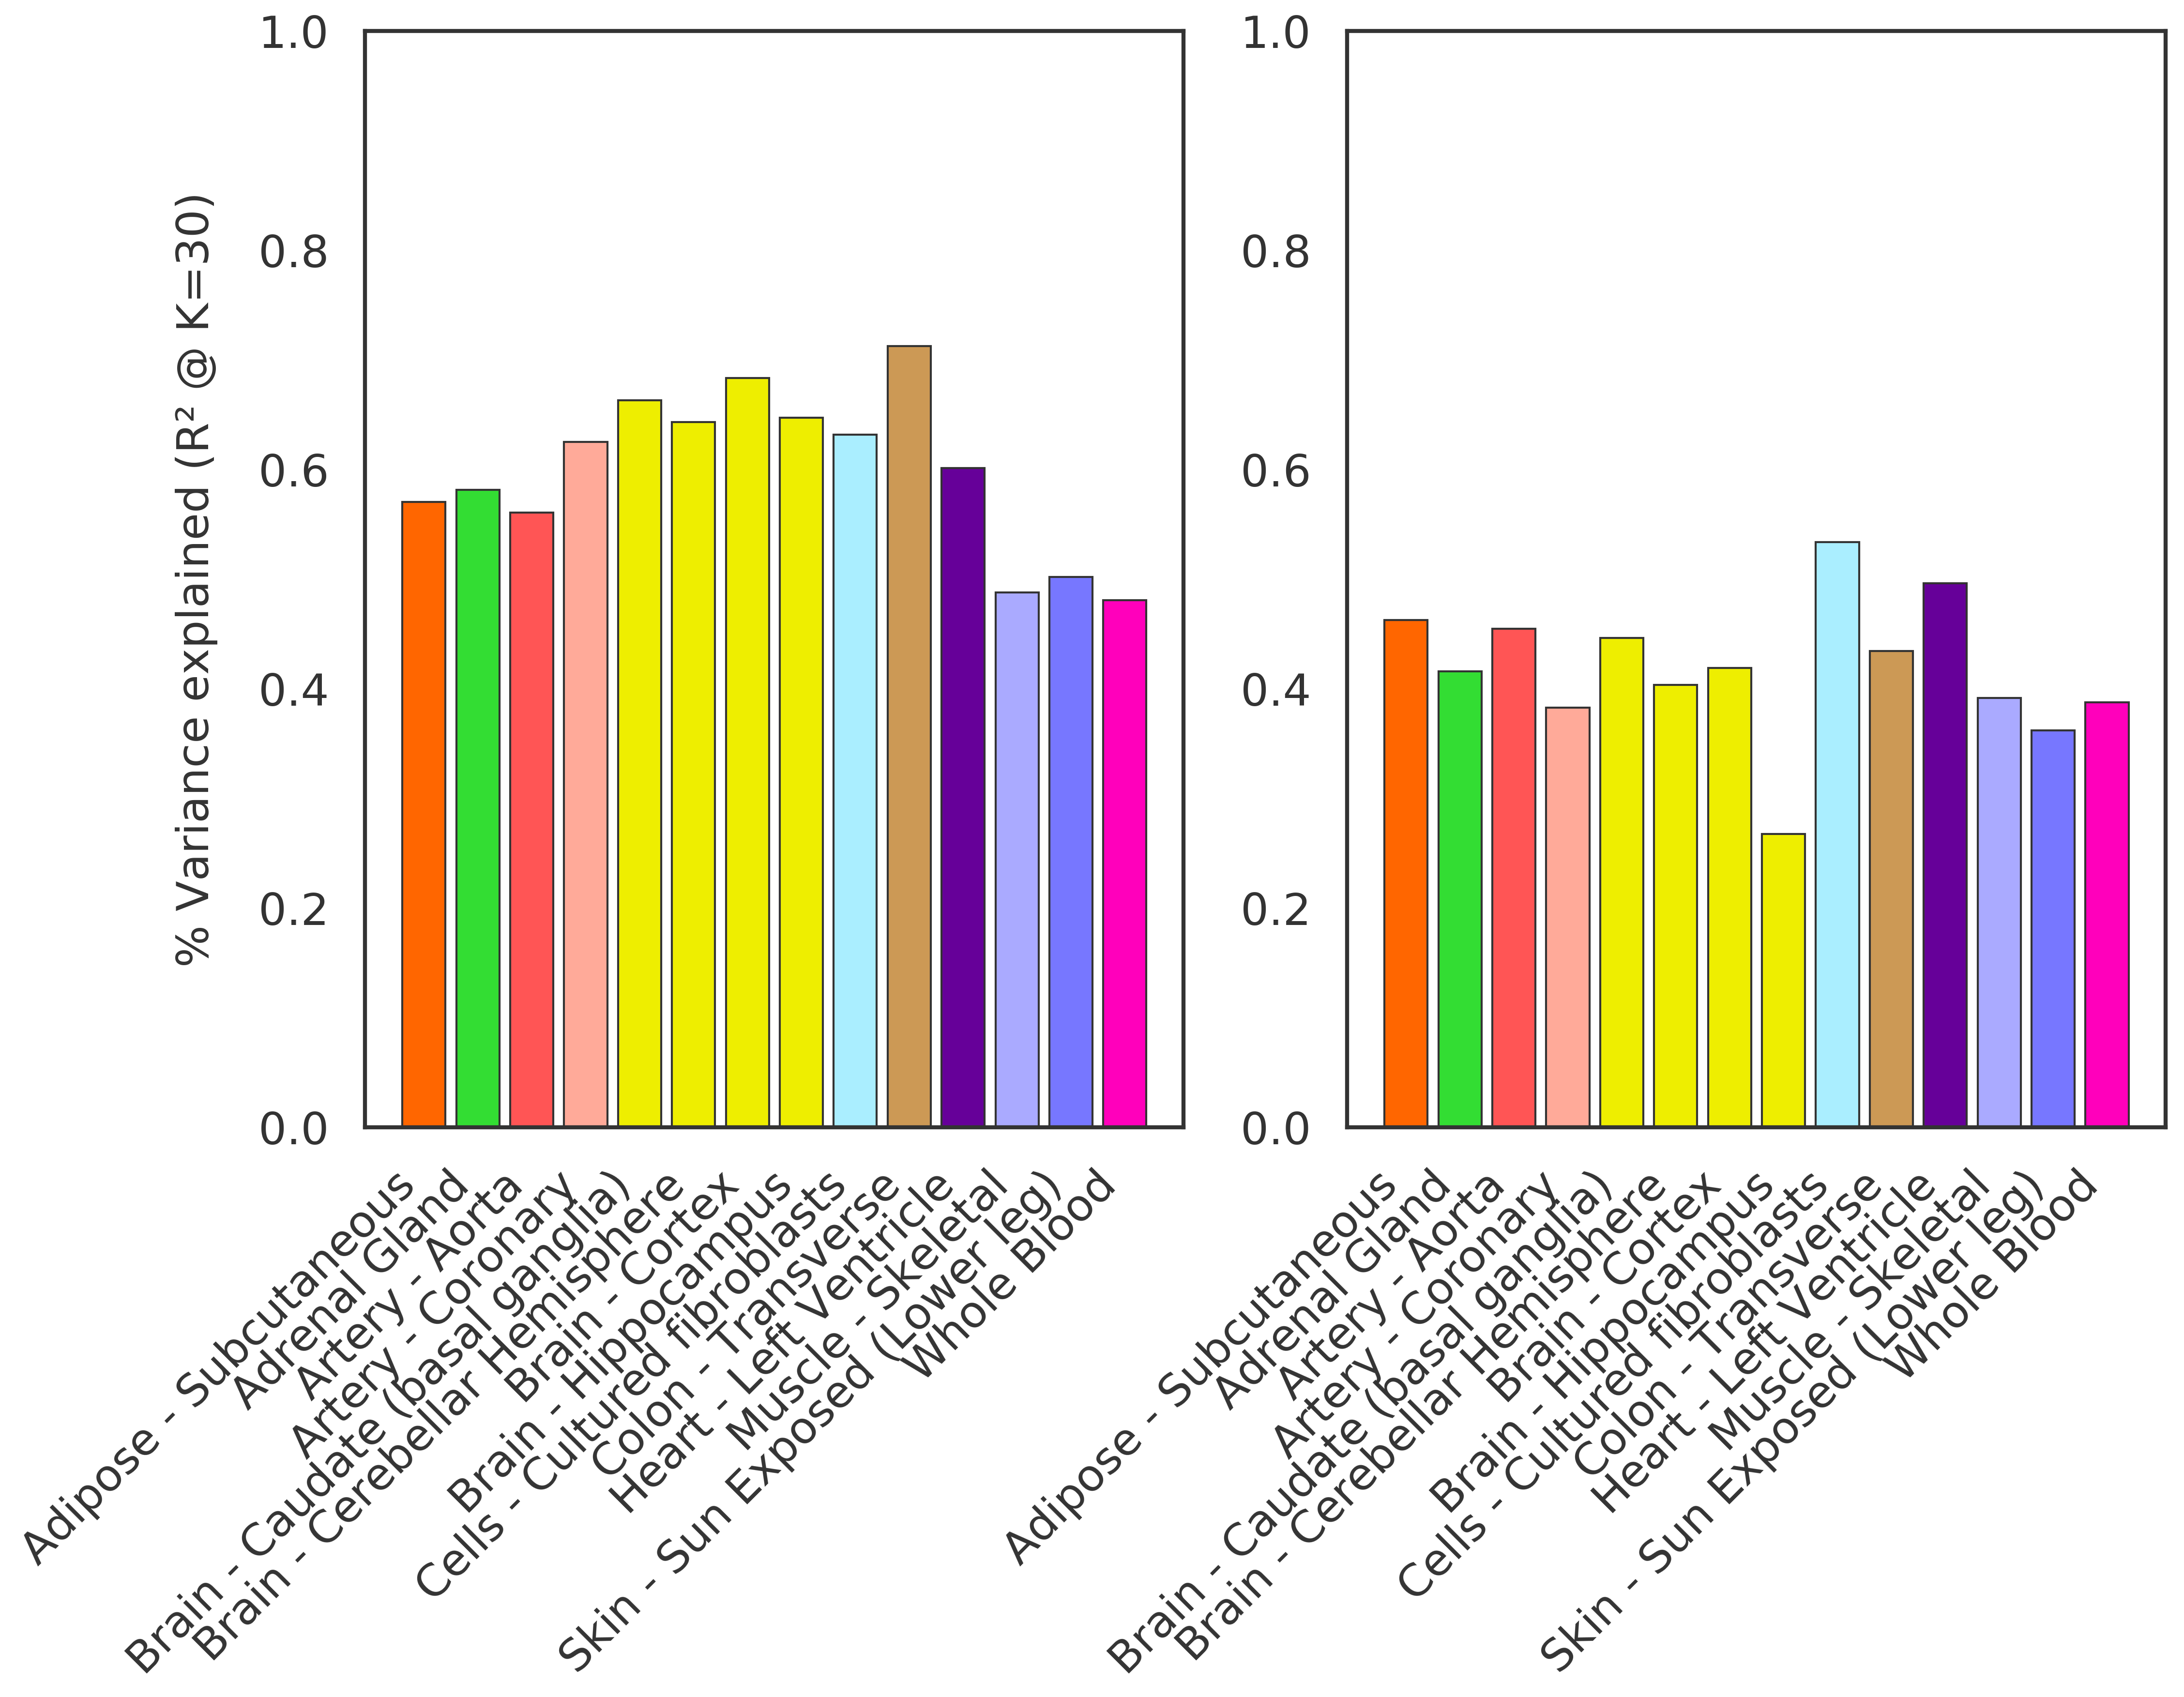

In [32]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

fig = plt.figure(figsize=(16,10))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)
x = [x[0] for x in multi_r2]
y = [x[1] for x in multi_r2]
ax1.bar(x, y, color=[tissue_colors[i] for i in x])
ax1.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
ax1.set_ylabel("% Variance explained (R² @ K=30)")
ax1.set_ylim(0,1)

x = [x[0] for x in multi_r2_c]
y = [x[1] for x in multi_r2_c]
ax2.bar(x, y, color=[tissue_colors[i] for i in x])
ax2.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
# ax2.set_ylabel("% Variance explained (R² @ K=30)")
ax2.set_ylim(0,1)
plt.show()


In [34]:
knn_cov_r2

as        ag        aa        ac       bca      bceh  \
AGE          0.027372  0.009873  0.024596  0.009392  0.017641  0.014506   
AGE2         0.026379  0.012013  0.026222  0.010310  0.016536  0.014356   
AGE3         0.024739  0.013726  0.026987  0.011091  0.015578  0.014051   
COHORT_0     0.087227  0.163655  0.136385  0.075094       NaN       NaN   
COHORT_1     0.086473  0.163655  0.136385  0.075094       NaN       NaN   
COHORT_2     0.040262       NaN       NaN       NaN       NaN       NaN   
DTHATPSY     0.026351  0.045840  0.044740  0.041356  0.003511  0.003282   
DTHHRDY      0.064369  0.148002  0.086617  0.050782  0.038658  0.016594   
DTHPLCE      0.036210  0.075757  0.065156  0.028938  0.007282  0.008620   
DTHRFG       0.046418  0.105649  0.085603  0.049085  0.003602  0.003574   
DTHVNT       0.003187  0.002004  0.001286  0.002685  0.004082  0.003215   
DTHVNTD      0.006920  0.010705  0.006573  0.016658       NaN       NaN   
ETHNCTY      0.035204  0.096009  0.061010  0.046011  0.006677  0.007168   
LBCMVTAB     0.095401  0.198028  0.141763  0.087874  0.005454  0.008570   
LBEBVGAB     0.084701  0.161085  0.119054  0.082110       NaN  0.003115   
LBEBVMAB     0.086730  0.182092  0.124463  0.083314       NaN  0.003115   
LBHBCABM     0.020260  0.043093  0.039570  0.021676  0.007870  0.005106   
LBPRRVDRL    0.028029  0.064568  0.052673  0.024833  0.007823  0.006413   
MHABNWBC     0.000718  0.002729  0.001325  0.008840  0.002673  0.005101   
MHSRC_0      0.013980  0.024548  0.033089  0.011360  0.004308  0.005041   
MHSRC_1      0.013980  0.024548  0.033089  0.011360  0.004308  0.005041   
PC1          0.291261  0.120730  0.132319  0.122631  0.192211  0.217909   
PC2          0.002822  0.007239  0.002918  0.003067  0.004123  0.005541   
PC3          0.001234  0.002754  0.005439  0.004638  0.008433  0.005071   
PC4          0.002690  0.006217  0.003934  0.002107  0.006801  0.002803   
PC5          0.003637  0.006173  0.003240  0.007262  0.003498  0.004936   
RACE         0.002036  0.003819  0.001017  0.003264  0.159154  0.188866   
SEX          0.006040  0.002958  0.003785  0.010515  0.002209  0.006194   
SMALTALG     0.001256  0.017834  0.007017  0.005349  0.054464  0.029114   
SMATSSCR     0.005346  0.102984  0.012181  0.008801       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
SMGEBTCH     0.005162  0.004567  0.008416  0.017652  0.006876  0.017933   
SMGEBTCHD    0.003062  0.003134  0.009451  0.014154  0.005919  0.017975   
SMGNSDTC     0.033127  0.018393  0.055147  0.067199  0.036674  0.013905   
SMMAPRT      0.002000  0.003284  0.003820  0.005256  0.006395  0.005537   
SMMFLGTH     0.006143  0.005540  0.014997  0.015803  0.026347  0.018838   
SMMPPD       0.002832  0.002918  0.002118  0.004536  0.008156  0.005594   
SMMPPDPR     0.002810  0.002925  0.002214  0.004556  0.008228  0.005619   
SMMPPDUN     0.002832  0.002918  0.002118  0.004536  0.008156  0.005594   
SMMPUNRT     0.002000  0.003284  0.003820  0.005256  0.006395  0.005537   
SMNABTCH     0.005386  0.005517  0.010788  0.011440  0.006729  0.013648   
SMNABTCHD    0.004760  0.004451  0.010661  0.011648  0.006071  0.014143   
SMNABTCHT_0  0.003695  0.005931  0.009589  0.012176       NaN       NaN   
SMNABTCHT_3  0.003695  0.005931  0.009589  0.012176       NaN       NaN   
SMNTERRT     0.005407  0.082822  0.055583  0.019387  0.027526  0.029699   
SMNTRART     0.005426  0.081379  0.055572  0.019850  0.028267  0.029881   
SMNTRNRT     0.096929  0.061092  0.240000  0.165121  0.069354  0.088766   
SMRDTTL      0.003271  0.002847  0.001976  0.004486  0.007298  0.005397   
SMRIN        0.012258  0.154258  0.034136  0.042388  0.082635  0.058795   
SMRRNANM     0.007517  0.073873  0.008496  0.023535  0.114901  0.068066   
SMRRNART     0.008095  0.080077  0.011357  0.029543  0.152318  0.076579   
SMSFLGTH     0.004940  0.005052  0.013336  0.015828  0.024931  0.016723   
SMSPLTRD     0.002657  0.038359  0.032163  0

# What can KNN learn from the public GTEx Covariates?

In [39]:
res_dict = dict()
for tissue in tshorts:
    if tissue not in select_tissues:
        continue
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    gx_corr, nb_comp = knn_correction(expression.T, 30)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

#     # Covariates have size Covariates (rows) x Nsamples (columns)
#     cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
#     df_cov = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
#     sort_cov_df = scale_covariates(df_cov[nb_df.columns])

    # Covariates have size Covariates (rows) x Nsamples (columns)
    
    # PUBLIC Covariates
    cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
    df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
    # SUBJECT covariates
    df_cov = SUBJ_DF.T.copy(deep=True)
    df_cov.columns = df_cov.loc["SUBJID"]
    df_cov.drop(["SUBJID"], inplace=True)
    
    # SAMPLE covariates
    TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
    new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
    TISSUE_SAMPLE_DF.columns = new_columns
    TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

    # Concat all covariates and delete those that only have one category
    ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
    TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
    # subset covariates that had r^2 larger than R2_cutoff
    covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
    print("Subsetting to {:d} covariates and {:d} samples".format(len(covname_list_c), len(nb_df.columns)))
    
    # Filling NaN with zeroes! awful!
    sort_cov_df = scale_covariates_nan(TISSUE_COVS.loc[covname_list_c,nb_df.columns]).fillna(0)

    
    # Multiple Linear regression of all covariates agains KNN component of expression
    r2_list = list()
    xpos = list()
    for K in range(5,100,5):
        print("K ={:>3} - ".format(K), end="")
        gx_corr, nb_comp = knn_correction(expression.T, K)
        nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
        reg = linear_model.LinearRegression()
        X = sort_cov_df.T ## (12, 581,)
        Y = nb_df.T 
        reg.fit(X, Y)
        r2 = reg.score(X, Y)
        r2_list.append(r2)
        xpos.append(K)
        print("R^2 : {:g}".format(r2))

    for K in range(100,len(expr_donors),50):
        print("K ={:>3} - ".format(K), end="")
        gx_corr, nb_comp = knn_correction(expression.T, K)
        nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
        reg = linear_model.LinearRegression()
        X = sort_cov_df.T ## (12, 581,)
        Y = nb_df.T 
        reg.fit(X, Y)
        r2 = reg.score(X, Y)
        r2_list.append(r2)
        xpos.append(K)
        print("R^2 : {:g}".format(r2))
    res_dict[tissue] = [xpos,r2_list]

as
Subsetting to 13 covariates and 581 samples
K =  5 - R^2 : 0.248029
K = 10 - R^2 : 0.326218
K = 15 - R^2 : 0.383603
K = 20 - R^2 : 0.413711
K = 25 - R^2 : 0.44263
K = 30 - R^2 : 0.462654
K = 35 - R^2 : 0.480794
K = 40 - R^2 : 0.492834
K = 45 - R^2 : 0.498507
K = 50 - R^2 : 0.504911
K = 55 - R^2 : 0.508292
K = 60 - R^2 : 0.515085
K = 65 - R^2 : 0.516849
K = 70 - R^2 : 0.516855
K = 75 - R^2 : 0.515573
K = 80 - R^2 : 0.515933
K = 85 - R^2 : 0.516292
K = 90 - R^2 : 0.512008
K = 95 - R^2 : 0.511655
K =100 - R^2 : 0.510324
K =150 - R^2 : 0.485381
K =200 - R^2 : 0.452201
K =250 - R^2 : 0.426907
K =300 - R^2 : 0.396165
K =350 - R^2 : 0.363392
K =400 - R^2 : 0.338084
K =450 - R^2 : 0.307935
K =500 - R^2 : 0.242047
K =550 - R^2 : 0.166959
ag
Subsetting to 26 covariates and 233 samples
K =  5 - R^2 : 0.374733
K = 10 - R^2 : 0.415356
K = 15 - R^2 : 0.403731
K = 20 - R^2 : 0.402544
K = 25 - R^2 : 0.409776
K = 30 - R^2 : 0.415586
K = 35 - R^2 : 0.417456
K = 40 - R^2 : 0.42568
K = 45 - R^2 : 0.427

K =400 - R^2 : 0.241645
K =450 - R^2 : 0.205306
K =500 - R^2 : 0.187808
K =550 - R^2 : 0.141501
K =600 - R^2 : 0.0620397
wb
Subsetting to 22 covariates and 670 samples
K =  5 - R^2 : 0.294684
K = 10 - R^2 : 0.349231
K = 15 - R^2 : 0.373043
K = 20 - R^2 : 0.382915
K = 25 - R^2 : 0.386438
K = 30 - R^2 : 0.387659
K = 35 - R^2 : 0.385112
K = 40 - R^2 : 0.38114
K = 45 - R^2 : 0.377498
K = 50 - R^2 : 0.373549
K = 55 - R^2 : 0.369436
K = 60 - R^2 : 0.366192
K = 65 - R^2 : 0.362112
K = 70 - R^2 : 0.359167
K = 75 - R^2 : 0.357399
K = 80 - R^2 : 0.356564
K = 85 - R^2 : 0.355904
K = 90 - R^2 : 0.352678
K = 95 - R^2 : 0.350398
K =100 - R^2 : 0.350158
K =150 - R^2 : 0.34944
K =200 - R^2 : 0.369865
K =250 - R^2 : 0.378873
K =300 - R^2 : 0.390772
K =350 - R^2 : 0.410426
K =400 - R^2 : 0.421778
K =450 - R^2 : 0.410491
K =500 - R^2 : 0.400595
K =550 - R^2 : 0.408322
K =600 - R^2 : 0.385014
K =650 - R^2 : 0.291652


In [40]:
# import json
# json_dict = json.dumps(res_dict)
# with open("KNN_components.json", 'w') as outstream:
#     outstream.write(json_dict)

json_dict = json.dumps(res_dict)
with open("KNN_components_more_covariates.json", 'w') as outstream:
    outstream.write(json_dict)

In [ ]:
import json
with open("KNN_components.json") as handle:
    res_dict = json.loads(handle.read())

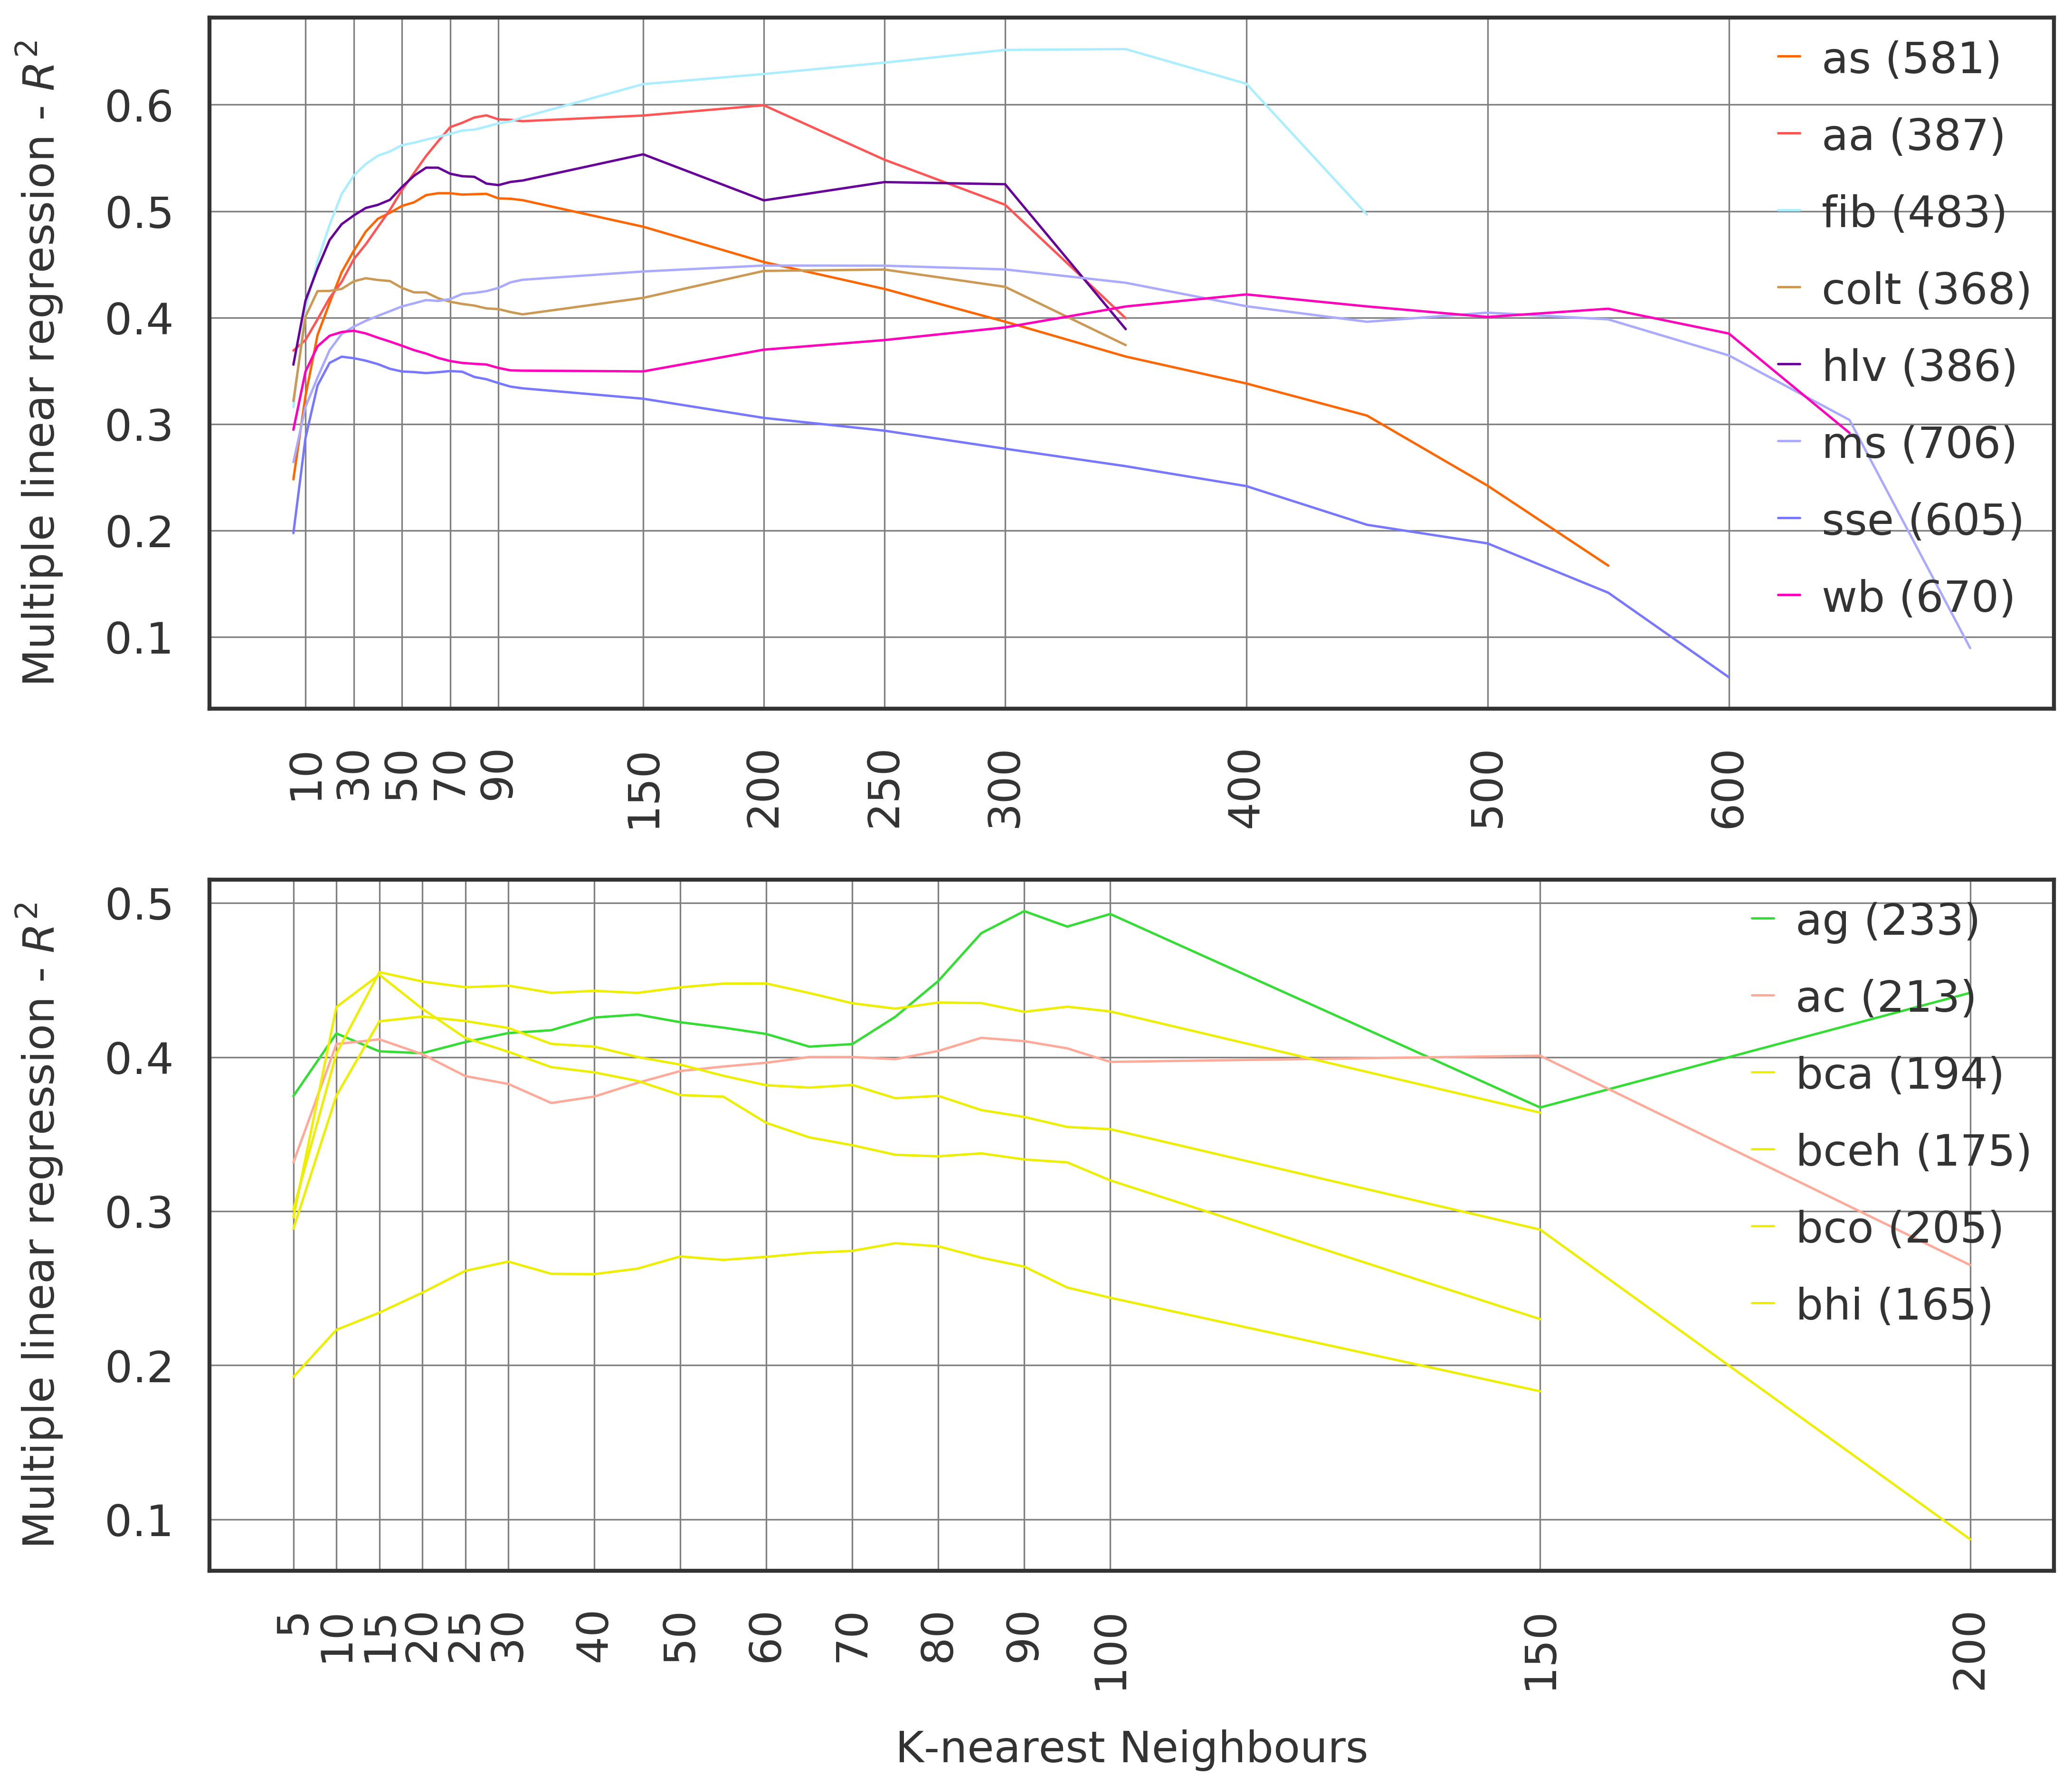

In [68]:
import json
import os 
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

json_file = "../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]


fig = plt.figure(figsize = (15, 13))
ax1 = fig.add_subplot(211)    
ax2 = fig.add_subplot(212)    
    
for tissue in tshorts:
    if tissue in select_tissues:

        if tissue_samples[tissue] < 260:
            X = res_dict[tissue][0]#[:22]
            Y = res_dict[tissue][1]#[:22]
            ax2.plot(X, Y, label=f"{tissue} ({tissue_samples[tissue]})", color=tissue_colors[tissue])
        else:
            X = res_dict[tissue][0]#[:22]
            Y = res_dict[tissue][1]#[:22]
            ax1.plot(X, Y, label=f"{tissue} ({tissue_samples[tissue]})", color=tissue_colors[tissue])

# ax1.set_xlabel("K-nearest Neighbours")
ax1ticks = [10,30,50,70,90,150, 200,250,300,400,500,600]
ax1.set_xticks(ax1ticks)
ax1.set_xticklabels(ax1ticks, rotation=90)
ax1.set_ylabel("Multiple linear regression - $R^2$")
ax2.set_xlabel("K-nearest Neighbours")

ax2ticks = [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]
ax2.set_xticks(ax2ticks) #,250,300,400,500,600])
ax2.set_xticklabels(ax2ticks, rotation=90)

ax2.set_ylabel("Multiple linear regression - $R^2$")
ax1.legend()
ax2.legend()
ax1.grid(True, color='gray')
ax2.grid(True, color='gray')
plt.tight_layout()
plt.show()
        

In [13]:
def knn_correction_dev(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn, neighbour_comp

In [132]:
import collections

def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

res_dict = collections.defaultdict(dict)
for tissue in select_tissues:
    # tissue = "wb"
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    for f in [0.1, 0.2, 0.5, 0.8, 1]:
        print(f)
        gx_corr, nb_comp = knn_correction_dev(expression.T, 30, f)
        nb_df = normalize_expr(pd.DataFrame(nb_comp.T, columns = expr_donors))

        # Covariates have size Covariates (rows) x Nsamples (columns)

        # PUBLIC Covariates
        cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
        df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
        df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)

        # SUBJECT covariates
        df_cov = SUBJ_DF.T.copy(deep=True)
        df_cov.columns = df_cov.loc["SUBJID"]
        df_cov.drop(["SUBJID"], inplace=True)

        # SAMPLE covariates
        TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
        new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
        TISSUE_SAMPLE_DF.columns = new_columns
        TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

        # Concat all covariates and delete those that only have one category
        ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
        TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]

        # # subset covariates that had r^2 larger than R2_cutoff
        # covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
        # print("Subsetting to {:d} covariates and {:d} samples".format(len(covname_list_c), len(nb_df.columns)))

        # Filling NaN with zeroes! awful!
        # sort_cov_df = scale_covariates_nan(TISSUE_COVS.loc[covname_list_c,nb_df.columns]).fillna(0)
        sort_cov_df = scale_covariates_nan(TISSUE_COVS.loc[:,nb_df.columns]).fillna(0)

        # Multiple Linear regression of all covariates agains KNN component of expression
        r2_list = list()
        xpos = list()
        for K in range(5,100,5):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction_dev(expression.T, K, f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))

        for K in range(100,min(250, len(expr_donors)),50):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction_dev(expression.T, K, f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))
        res_dict[tissue][f] = [xpos,r2_list]

wb
0.1
K =  5 - R^2 : 0.339271
K = 10 - R^2 : 0.409765
K = 15 - R^2 : 0.442547
K = 20 - R^2 : 0.462037
K = 25 - R^2 : 0.475908
K = 30 - R^2 : 0.481517
K = 35 - R^2 : 0.486978
K = 40 - R^2 : 0.491161
K = 45 - R^2 : 0.493473
K = 50 - R^2 : 0.496333
K = 55 - R^2 : 0.498396
K = 60 - R^2 : 0.498657
K = 65 - R^2 : 0.497755
K = 70 - R^2 : 0.498328
K = 75 - R^2 : 0.498223
K = 80 - R^2 : 0.497453
K = 85 - R^2 : 0.497522
K = 90 - R^2 : 0.497609
K = 95 - R^2 : 0.497159
K =100 - R^2 : 0.49761
K =150 - R^2 : 0.49744
K =200 - R^2 : 0.494048
0.2
K =  5 - R^2 : 0.345684
K = 10 - R^2 : 0.417468
K = 15 - R^2 : 0.452566
K = 20 - R^2 : 0.471107
K = 25 - R^2 : 0.483681
K = 30 - R^2 : 0.490466
K = 35 - R^2 : 0.494705
K = 40 - R^2 : 0.497783
K = 45 - R^2 : 0.499597
K = 50 - R^2 : 0.500917
K = 55 - R^2 : 0.50051
K = 60 - R^2 : 0.501186
K = 65 - R^2 : 0.500165
K = 70 - R^2 : 0.499801
K = 75 - R^2 : 0.500026
K = 80 - R^2 : 0.499414
K = 85 - R^2 : 0.498334
K = 90 - R^2 : 0.497347
K = 95 - R^2 : 0.497458
K =100 -

In [133]:
import json
json_dict = json.dumps(res_dict)
# with open("KNN_fraction_of_componentes_in_dist_matrix_r2.json", 'w') as outstream:
#     outstream.write(json_dict)
    
# with open("KNN_fraction_of_componentes_in_dist_matrix_r2_scaled.json", 'w') as outstream:
#     outstream.write(json_dict)

In [136]:
with open("KNN_fraction_of_componentes_in_dist_matrix_r2.json") as infile:
    res_dict_o = json.load(infile)

# with open("KNN_fraction_of_componentes_in_dist_matrix_r2_scaled.json") as infile:
#     res_dict_scaled = json.load(infile)

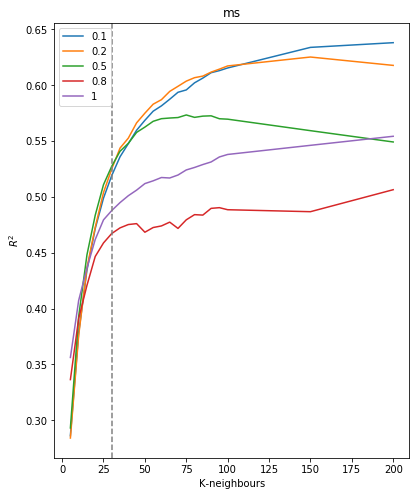

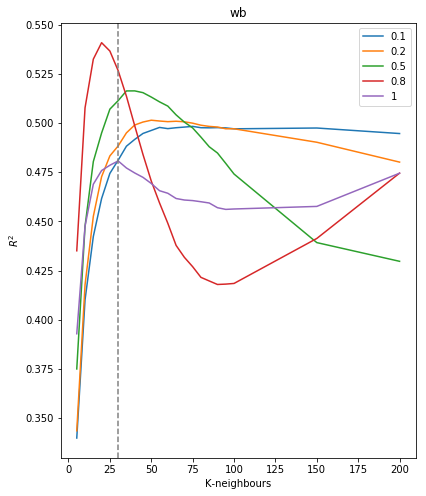

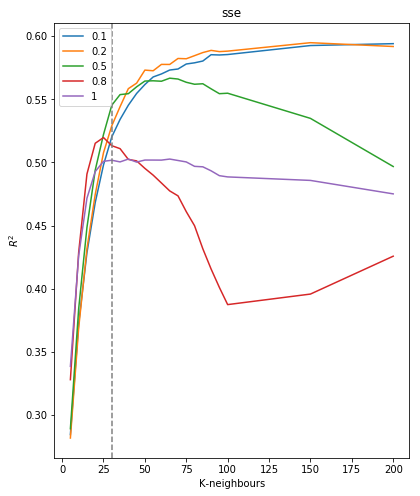

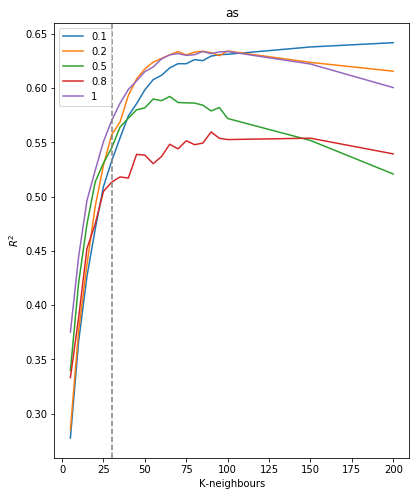

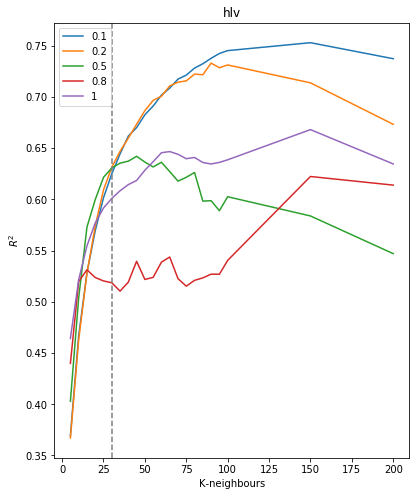

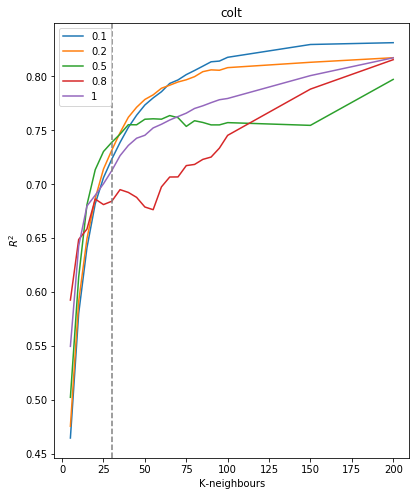

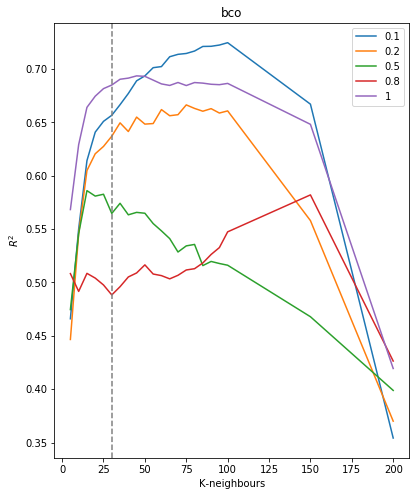

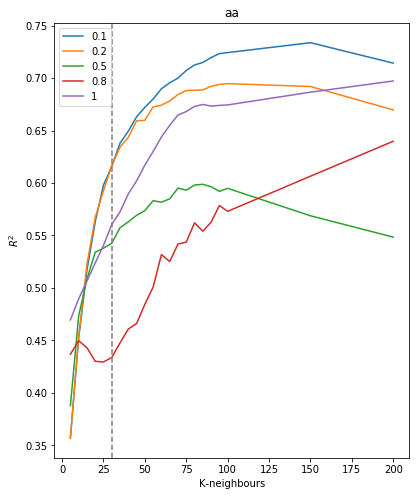

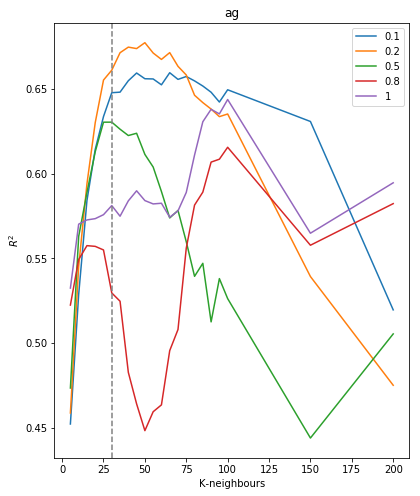

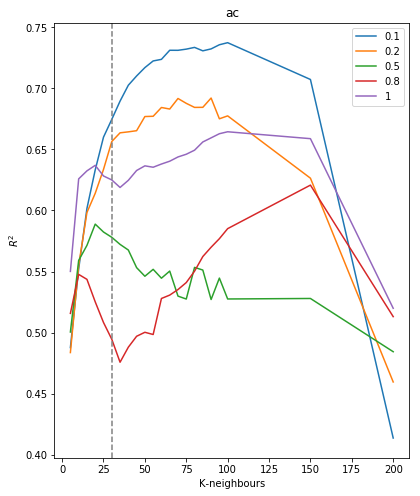

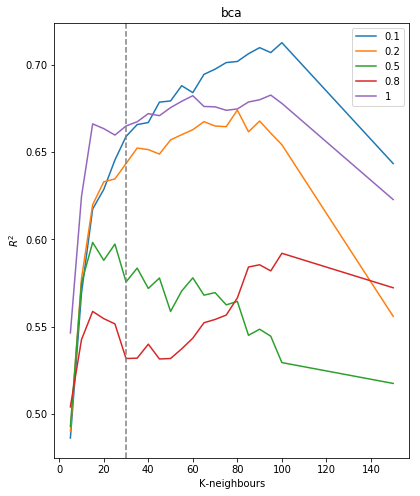

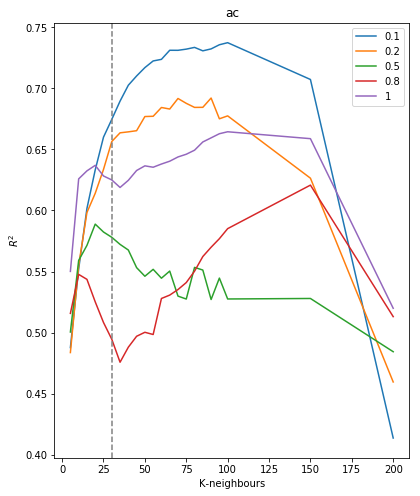

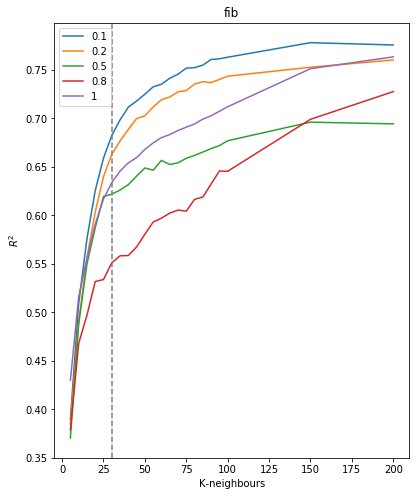

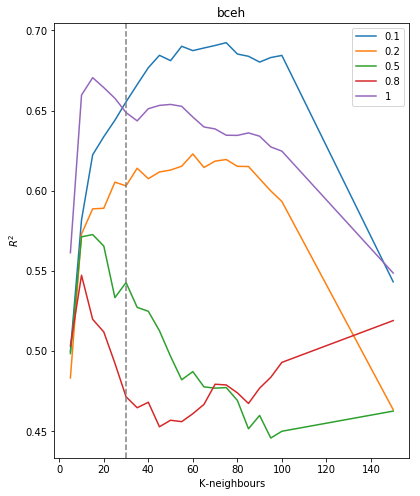

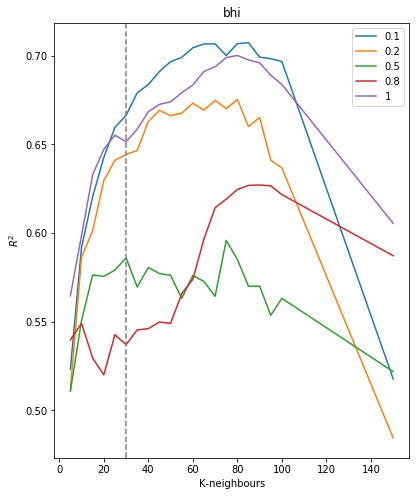

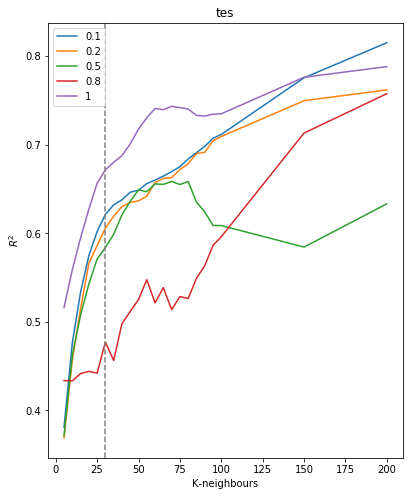

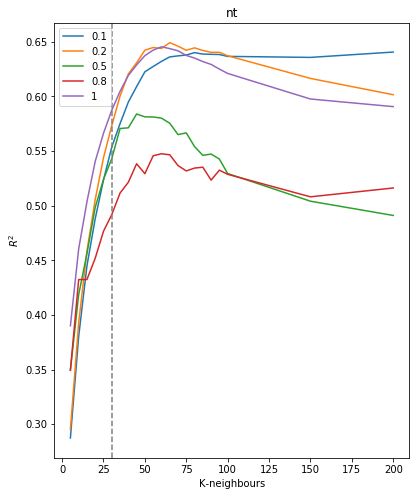

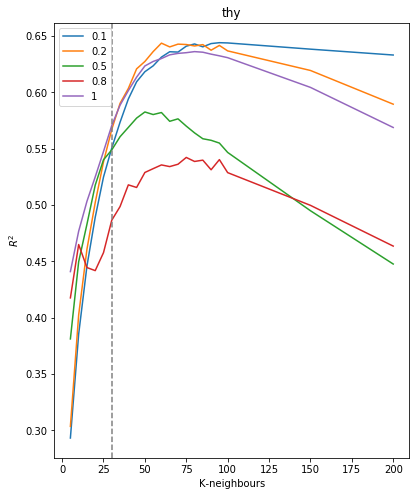

In [146]:

# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

for tissue in select_tissues:
    fig = plt.figure(figsize=(14,8))
    ax1  = fig.add_subplot(121)

    for f in [str(x) for x in [0.1, 0.2, 0.5, 0.8, 1]]:
        x, y = res_dict_o[tissue][f]
        ax1.plot(x, y, label=f)
    ax1.set_title(tissue)
    ax1.set_ylabel("$R^2$")
    ax1.set_xlabel("K-neighbours")
    ax1.axvline(30, color="gray", linestyle='--')
    ax1.legend()
    
    plt.savefig("../plots/KNN_PCA_fractions/{:s}.png".format(tissue))
    plt.show()

# The Whole Blood Problem

In [195]:
import re

def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent


def distmat(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
            
    return distance_matrix

def knn_correction_dev(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn, neighbour_comp

def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
    return samplenames

# for tissue in select_tissues:
tissue = "wb"
print(tissue)
gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
rpkm = ReadRPKM(gx_file, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
# samplenames = read_samples(samplefile)

# common = [x for x in expr_donors if x in samplenames]
# ix = [expr_donors.index(x) for x in common]
# expression_eur = expression[:, ix]

wb


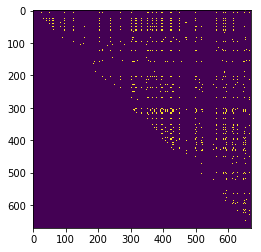

In [225]:
distance_matrix = distmat(expression.T, 30, 0.1)
df = pd.DataFrame(distance_matrix, columns=expr_donors)
mix = np.triu(distance_matrix <= 30, k=1)
plt.imshow(mix)

In [226]:
col_ix = np.sum(mix, axis=0)
collinear_samples_ix = np.where(col_ix > 0)[0]
exclude_samples = [expr_donors[i] for i in collinear_samples_ix]
len(exclude_samples)

327

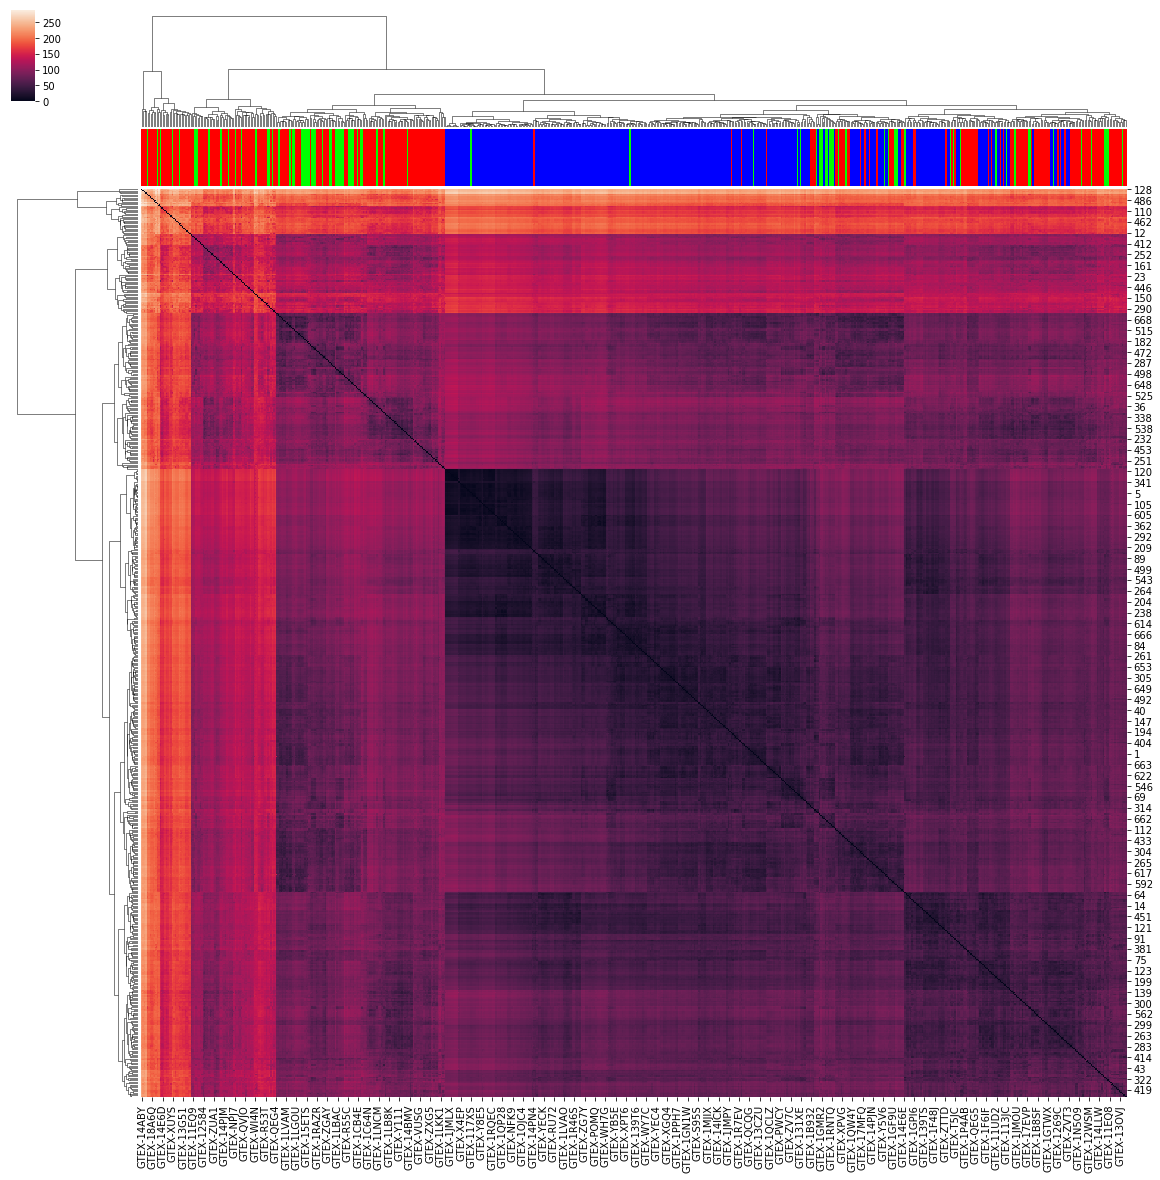

In [216]:
col_colors = list()
for n in expr_donors:
    if n in exclude_samples:
        col_colors.append("#0000ff")
    elif n in samplenames:
        col_colors.append("#ff0000")
    else:
        col_colors.append("#00ff00")
import seaborn as sn
h = sn.clustermap(df, col_colors=col_colors, figsize=(20,20) )       

In [217]:
donor_subset = [x for x in expr_donors if x not in exclude_samples]
subset_ix    = [expr_donors.index(x) for x in donor_subset]
expression_sub = expression[:, subset_ix]



In [218]:
df_sub = pd.DataFrame(expression_sub, columns = donor_subset, index=gene_names)
gx_out_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/{:s}_tpms_qcfilter.collinear_filtered.txt.protein_coding_lncRNA_filtered".format(tissue)
# with open(gx_out_file, 'w') as outf:
#     df_sub.to_csv(outf, header=True, index=True, sep="\t")

In [219]:
df_sub.head()

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  \
ENSG00000230021.8    -0.044691   -0.124168   -0.112153   -0.028388   
ENSG00000228794.8     0.059766   -0.580565   -0.580565    1.495953   
ENSG00000225880.5     0.204970   -0.503639   -0.503639    1.743607   
ENSG00000188976.10   -0.321969    0.359389    2.552199    0.006300   
ENSG00000187961.13   -0.574232   -0.233863    3.080014   -0.369683   

                    GTEX-113JC  GTEX-117XS  GTEX-117YW  GTEX-1192X  \
ENSG00000230021.8    -0.130072   -0.129259   -0.138081   -0.066005   
ENSG00000228794.8    -0.580565   -0.504158   -0.244078   -0.580565   
ENSG00000225880.5    -0.503639   -0.503639   -0.503639   -0.503639   
ENSG00000188976.10   -0.712317   -0.132866   -0.178751   -0.066754   
ENSG00000187961.13   -0.347577   -0.446189    1.794754    0.541542   

                    GTEX-11DXZ  GTEX-11EI6    ...      GTEX-ZEX8  GTEX-ZF28  \
ENSG00000230021.8    -0.024456   -0.112384    ...      -0.125835  -0.016984   
ENSG00000228794.8     2.243357   -0.580565    ...      -0.580565   1.936565   
ENSG00000225880.5     0.845809   -0.503639    ...      -0.503639   2.390701   
ENSG00000188976.10    0.473526    0.864306    ...       0.399149   2.020928   
ENSG00000187961.13   -0.079283    1.572147    ...      -0.213191   1.447102   

                    GTEX-ZF2S  GTEX-ZF3C  GTEX-ZGAY  GTEX-ZPCL  GTEX-ZUA1  \
ENSG00000230021.8   -0.047814  -0.115915   0.178405  -0.105164  -0.097757   
ENSG00000228794.8   -0.059371   0.067357  -0.066620  -0.580565  -0.580565   
ENSG00000225880.5   -0.161182  -0.503639  -0.053381  -0.503639  -0.503639   
ENSG00000188976.10   1.802985   4.608363  -0.665073  -0.024382   1.791818   
ENSG00000187961.13   1.201251   2.386723  -0.566804  -0.311606   0.322188   

                    GTEX-ZV68  GTEX-ZXES  GTEX-ZXG5  
ENSG00000230021.8   -0.038654  -0.101285  -0.101776  
ENSG00000228794.8    0.149522  -0.580565  -0.344739  
ENSG00000225880.5    1.415210  -0.503639  -0.503639  
ENSG00000188976.10  -0.681342   0.243429  -0.403403  
ENSG00000187961.13  -0.601663  -0.358488   2.325512  

[5 rows x 347 columns]

In [220]:
df_expr = pd.DataFrame(expression, columns = expr_donors, index=gene_names)
df_expr.head()

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  \
ENSG00000230021.8    -0.044691   -0.124168   -0.112153   -0.028388   
ENSG00000228794.8     0.059766   -0.580565   -0.580565    1.495953   
ENSG00000225880.5     0.204970   -0.503639   -0.503639    1.743607   
ENSG00000188976.10   -0.321969    0.359389    2.552199    0.006300   
ENSG00000187961.13   -0.574232   -0.233863    3.080014   -0.369683   

                    GTEX-113JC  GTEX-117XS  GTEX-117YW  GTEX-1192W  \
ENSG00000230021.8    -0.130072   -0.129259   -0.138081   -0.108890   
ENSG00000228794.8    -0.580565   -0.504158   -0.244078   -0.428872   
ENSG00000225880.5    -0.503639   -0.503639   -0.503639   -0.503639   
ENSG00000188976.10   -0.712317   -0.132866   -0.178751   -0.063908   
ENSG00000187961.13   -0.347577   -0.446189    1.794754   -0.601663   

                    GTEX-1192X  GTEX-11DXX    ...      GTEX-ZV7C  GTEX-ZVE2  \
ENSG00000230021.8    -0.066005   -0.122966    ...      -0.093154  -0.087506   
ENSG00000228794.8    -0.580565   -0.547837    ...      -0.219245  -0.580565   
ENSG00000225880.5    -0.503639   -0.503639    ...      -0.138393  -0.503639   
ENSG00000188976.10   -0.066754   -0.522784    ...       0.061828   0.478378   
ENSG00000187961.13    0.541542   -0.521750    ...      -0.058730  -0.601663   

                    GTEX-ZVP2  GTEX-ZVT2  GTEX-ZVT3  GTEX-ZVT4  GTEX-ZVZP  \
ENSG00000230021.8   -0.074197  -0.040803  -0.130727  -0.138081  -0.113854   
ENSG00000228794.8   -0.373080  -0.208869  -0.580565  -0.544316  -0.440676   
ENSG00000225880.5    0.041683  -0.503639  -0.503639  -0.503639  -0.503639   
ENSG00000188976.10  -0.712317  -0.712317   3.266133  -0.712317  -0.693028   
ENSG00000187961.13  -0.475005  -0.601663   4.064097  -0.572159  -0.601663   

                    GTEX-ZVZQ  GTEX-ZXES  GTEX-ZXG5  
ENSG00000230021.8   -0.104504  -0.101285  -0.101776  
ENSG00000228794.8   -0.580565  -0.580565  -0.344739  
ENSG00000225880.5   -0.503639  -0.503639  -0.503639  
ENSG00000188976.10   0.851540   0.243429  -0.403403  
ENSG00000187961.13  -0.601663  -0.358488   2.325512  

[5 rows x 670 columns]

In [221]:
gx_corr_1, nb_comp_1 = knn_correction_dev(expression.T, 30, 0.1)
gx_corr_2, nb_comp_2 = knn_correction_dev(expression.T, 30, 0.2)
gx_corr_3, nb_comp_3 = knn_correction_dev(expression.T, 30, 1)

gx_corr_1sub, nb_comp_1sub = knn_correction_dev(expression_sub.T, 30, 0.1)
gx_corr_2sub, nb_comp_2sub = knn_correction_dev(expression_sub.T, 30, 0.2)
gx_corr_3sub, nb_comp_3sub = knn_correction_dev(expression_sub.T, 30, 1)

In [228]:
print(expression.shape)
print(a.shape)
print(gx_corr_3.shape)
print(normalize_expr(gx_corr_3.T).shape)

a = normalize_expr(expression)
print("N", np.mean(expression, axis=1).shape)
print(np.mean(expression, axis=1))
print(np.std(expression, axis=1))

print(np.mean(a, axis=1))
print(np.std(a, axis=1))

print(np.mean(gx_corr_3.T, axis=1))
print(np.std(gx_corr_3.T, axis=1))

print(np.mean(normalize_expr(gx_corr_3.T), axis=1))
print(np.std(normalize_expr(gx_corr_3.T), axis=1))


(12046, 670)
(12046, 670)
(670, 12046)
(12046, 670)
N (12046,)
[ 1.32563943e-18 -1.59076732e-17 -5.30255773e-18 ...  3.97691830e-18
 -3.44666252e-17  1.85589521e-17]
[1. 1. 1. ... 1. 1. 1.]
[ 1.32563943e-18 -5.30255773e-18 -5.30255773e-18 ... -1.59076732e-17
 -1.32563943e-17  7.95383659e-18]
[1. 1. 1. ... 1. 1. 1.]
[0.09756153 0.30602674 0.25649821 ... 0.35771126 0.59311813 0.4486224 ]
[1.00113392 0.92405362 0.94323165 ... 0.95909234 0.93765952 0.89299521]
[ 0.00000000e+00  3.44666252e-17 -5.30255773e-18 ...  2.51871492e-17
  8.88178420e-17 -1.59076732e-17]
[1. 1. 1. ... 1. 1. 1.]


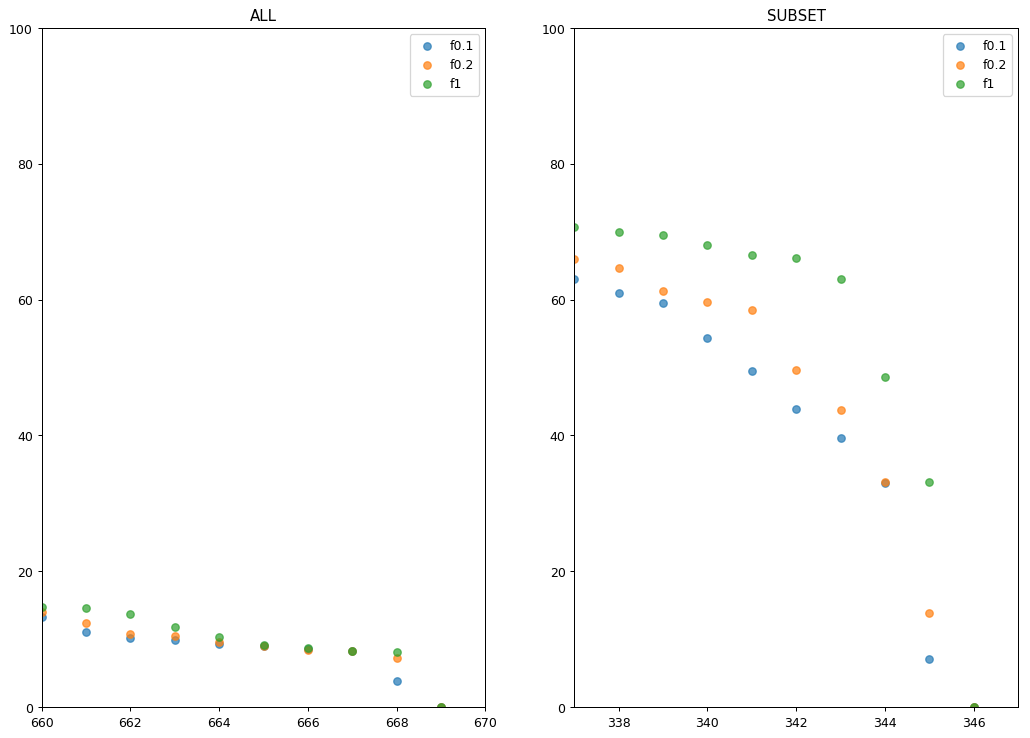

In [222]:
u1, ns1, v1 = np.linalg.svd(normalize_expr(gx_corr_1.T))
u2, ns2, v2 = np.linalg.svd(normalize_expr(gx_corr_2.T))
u3, ns3, v3 = np.linalg.svd(normalize_expr(gx_corr_3.T))

u1, s1, v1 = np.linalg.svd(normalize_expr(gx_corr_1sub.T))
u2, s2, v2 = np.linalg.svd(normalize_expr(gx_corr_2sub.T))
u3, s3, v3 = np.linalg.svd(normalize_expr(gx_corr_3sub.T))

fig = plt.figure(figsize=(14,10), dpi=90)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(np.arange(len(ns1)), ns1, label="f0.1", alpha=0.7)
ax1.scatter(np.arange(len(ns2)), ns2, label="f0.2", alpha=0.7)
ax1.scatter(np.arange(len(ns3)), ns3, label="f1", alpha=0.7)
ax1.set_xlim(len(ns1)-10,len(ns1))
ax1.set_ylim(0,100)
ax1.set_title("ALL")

ax2.scatter(np.arange(len(s1)), s1, label="f0.1", alpha=0.7)
ax2.scatter(np.arange(len(s2)), s2, label="f0.2", alpha=0.7)
ax2.scatter(np.arange(len(s3)), s3, label="f1", alpha=0.7)
ax2.set_xlim(len(s1)-10,len(s1))
ax2.set_ylim(0,100)
ax2.set_title("SUBSET")

ax1.legend()
ax2.legend()

plt.show()

wb


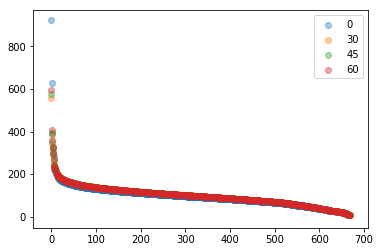

In [234]:
# for tissue in select_tissues:
tissue = "wb"
print(tissue)
gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
rpkm = ReadRPKM(gx_file, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

gx_0 = normalize_expr(expression)
gx_corr_1 = normalize_expr(knn_correction_dev(expression.T, 30, 1)[0].T)
gx_corr_2 = normalize_expr(knn_correction_dev(expression.T, 45, 1)[0].T)
gx_corr_3 = normalize_expr(knn_correction_dev(expression.T, 60, 1)[0].T)

u0, s0, v0 = np.linalg.svd(gx_0.T)
u1, s1, v1 = np.linalg.svd(gx_corr_1.T)
u2, s2, v2 = np.linalg.svd(gx_corr_2.T)
u3, s3, v3 = np.linalg.svd(gx_corr_3.T)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.scatter(np.arange(len(s0)-1), s0[:-1], label="0" , alpha=0.4 )
ax.scatter(np.arange(len(s1)-1), s1[:-1], label="30" , alpha=0.4 )
ax.scatter(np.arange(len(s2)-1), s2[:-1], label="45" , alpha=0.4 )
ax.scatter(np.arange(len(s3)-1), s3[:-1], label="60" , alpha=0.4 )
ax.legend()
plt.show()

670